# EDA
---
- 11/22

In [39]:
import pandas as pd
import polars as po
import tqdm

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import plotly as pl

from sklearn.cluster import KMeans

In [7]:
ori_df = pd.read_csv('../vehicles_processed.csv')
ori_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 115988 entries, 0 to 115987
Data columns (total 14 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            115988 non-null  int64  
 1   price         115988 non-null  int64  
 2   year          115988 non-null  float64
 3   manufacturer  115988 non-null  object 
 4   model         115988 non-null  object 
 5   condition     115988 non-null  object 
 6   cylinders     115988 non-null  object 
 7   fuel          115988 non-null  object 
 8   odometer      115988 non-null  float64
 9   transmission  115988 non-null  object 
 10  drive         115988 non-null  object 
 11  type          115988 non-null  object 
 12  paint_color   115988 non-null  object 
 13  description   115988 non-null  object 
dtypes: float64(2), int64(2), object(10)
memory usage: 12.4+ MB


### 이상치 정리

In [8]:
df = ori_df[(ori_df['price'] != 0)&(ori_df['odometer'] != 0)]
df.reset_index(drop=True, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 111427 entries, 0 to 111426
Data columns (total 14 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            111427 non-null  int64  
 1   price         111427 non-null  int64  
 2   year          111427 non-null  float64
 3   manufacturer  111427 non-null  object 
 4   model         111427 non-null  object 
 5   condition     111427 non-null  object 
 6   cylinders     111427 non-null  object 
 7   fuel          111427 non-null  object 
 8   odometer      111427 non-null  float64
 9   transmission  111427 non-null  object 
 10  drive         111427 non-null  object 
 11  type          111427 non-null  object 
 12  paint_color   111427 non-null  object 
 13  description   111427 non-null  object 
dtypes: float64(2), int64(2), object(10)
memory usage: 11.9+ MB


(array([187.,   5.,  10.,  25.,   9.,   8.,   4.,  14.,   3.,   4.,   5.,
         27.,   7.,   2.,   2.,  13.,   0.,   2.,   5.,   2.]),
 array([ 1. ,  3.4,  5.8,  8.2, 10.6, 13. , 15.4, 17.8, 20.2, 22.6, 25. ,
        27.4, 29.8, 32.2, 34.6, 37. , 39.4, 41.8, 44.2, 46.6, 49. ]),
 <BarContainer object of 20 artists>)

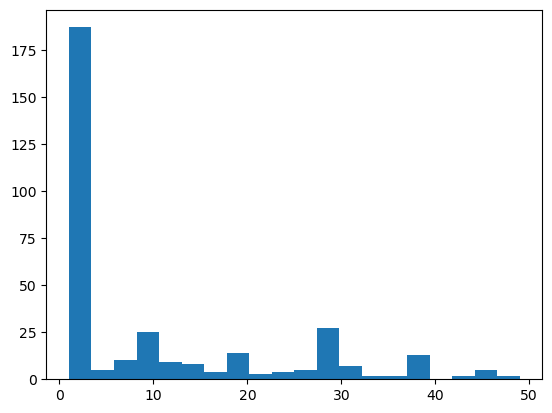

In [9]:
plt.hist(df[df['odometer'] < 50]['odometer'], bins=20)

(array([868.,   5.,   9.,   6.,  19.,   5.,   9.,   9.,  11.,   3.,   3.,
          2.,   3.,   2.,   6.,   1.,   1.,   1.,   0.,   0.,   1.,   2.,
          1.,   0.,   0.,   3.,   1.,   2.,   0.,   0.,   1.,   0.,   2.,
          0.,   0.,   1.,   0.,   0.,   1.,   0.,   3.,   1.,   0.,  22.,
          0.,   3.,   0.,   1.,   2.,   1.]),
 array([ 1.  ,  2.94,  4.88,  6.82,  8.76, 10.7 , 12.64, 14.58, 16.52,
        18.46, 20.4 , 22.34, 24.28, 26.22, 28.16, 30.1 , 32.04, 33.98,
        35.92, 37.86, 39.8 , 41.74, 43.68, 45.62, 47.56, 49.5 , 51.44,
        53.38, 55.32, 57.26, 59.2 , 61.14, 63.08, 65.02, 66.96, 68.9 ,
        70.84, 72.78, 74.72, 76.66, 78.6 , 80.54, 82.48, 84.42, 86.36,
        88.3 , 90.24, 92.18, 94.12, 96.06, 98.  ]),
 <BarContainer object of 50 artists>)

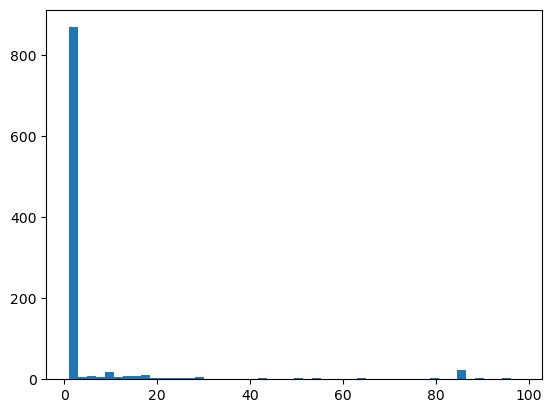

In [10]:
plt.hist(df[df['price'] < 100]['price'], bins=50)

- 가격, odormeter의 경우 0 값을 무의미한 값으로 봄
- 가격의 경우 20 이하는 무의미하다고 봐도 될 것 같음
- 주행거리의 경우, 10 이하는 무의미하다고 봐도 될 것 같음

## Basic EDA

### 연속형 데이터 
- 연도, 가격, odometer (주행 거리)

In [11]:
def describe_and_plot(data, column_name):
    
    Q1 = data[column_name].quantile(0.25)
    Q3 = data[column_name].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    filtered_data = data[(data[column_name] >= lower_bound) & (data[column_name] <= upper_bound)]

    # 이상치를 제외한 컬럼의 통계량 계산
    column_stats = filtered_data[column_name].describe()

    # 이상치를 제외한 컬럼의 히스토그램 그리기
    plt.figure(figsize=(30, 6))
    if column_name == 'price':
        plt.hist(filtered_data[column_name], bins=100, color='skyblue', edgecolor='gray')
    
    if column_name == 'odometer':
        plt.hist(filtered_data[column_name], bins=100, color='skyblue', edgecolor='gray')
    
    if column_name == 'year':
        plt.hist(filtered_data[column_name], bins=30, color='skyblue', edgecolor='gray')
        
    plt.title(f'Histogram of {column_name} without outliers')
    plt.xlabel(column_name)
    plt.ylabel('Frequency')
    plt.show()
    
    
    # 컬럼의 통계량 계산
    column_stats = data[column_name].describe()
    filtered_column_stats = filtered_data[column_name].describe()

    # 컬럼의 통계량 출력
    print("========================================================")
    print(f"Statistics for {column_name}:")
    print(f"Mean: {column_stats['mean']}")
    print(f"Standard Deviation: {column_stats['std']}")
    print(f"Variance: {column_stats['std']**2}")
    print(f"Minimum: {column_stats['min']}")
    print(f"25th Percentile: {np.percentile(data[column_name], 25)}")
    print(f"Median (50th Percentile): {column_stats['50%']}")
    print(f"75th Percentile: {np.percentile(data[column_name], 75)}")
    print(f"Maximum: {column_stats['max']}")
    print("========================================================")
    print(f"Statistics for {column_name} without outliers:")
    print(f"Mean: {filtered_column_stats['mean']}")
    print(f"Standard Deviation: {filtered_column_stats['std']}")
    print(f"Variance: {filtered_column_stats['std']**2}")
    print(f"Minimum: {filtered_column_stats['min']}")
    print(f"25th Percentile: {np.percentile(filtered_data[column_name], 25)}")
    print(f"Median (50th Percentile): {filtered_column_stats['50%']}")
    print(f"75th Percentile: {np.percentile(filtered_data[column_name], 75)}")
    print(f"Maximum: {filtered_column_stats['max']}")

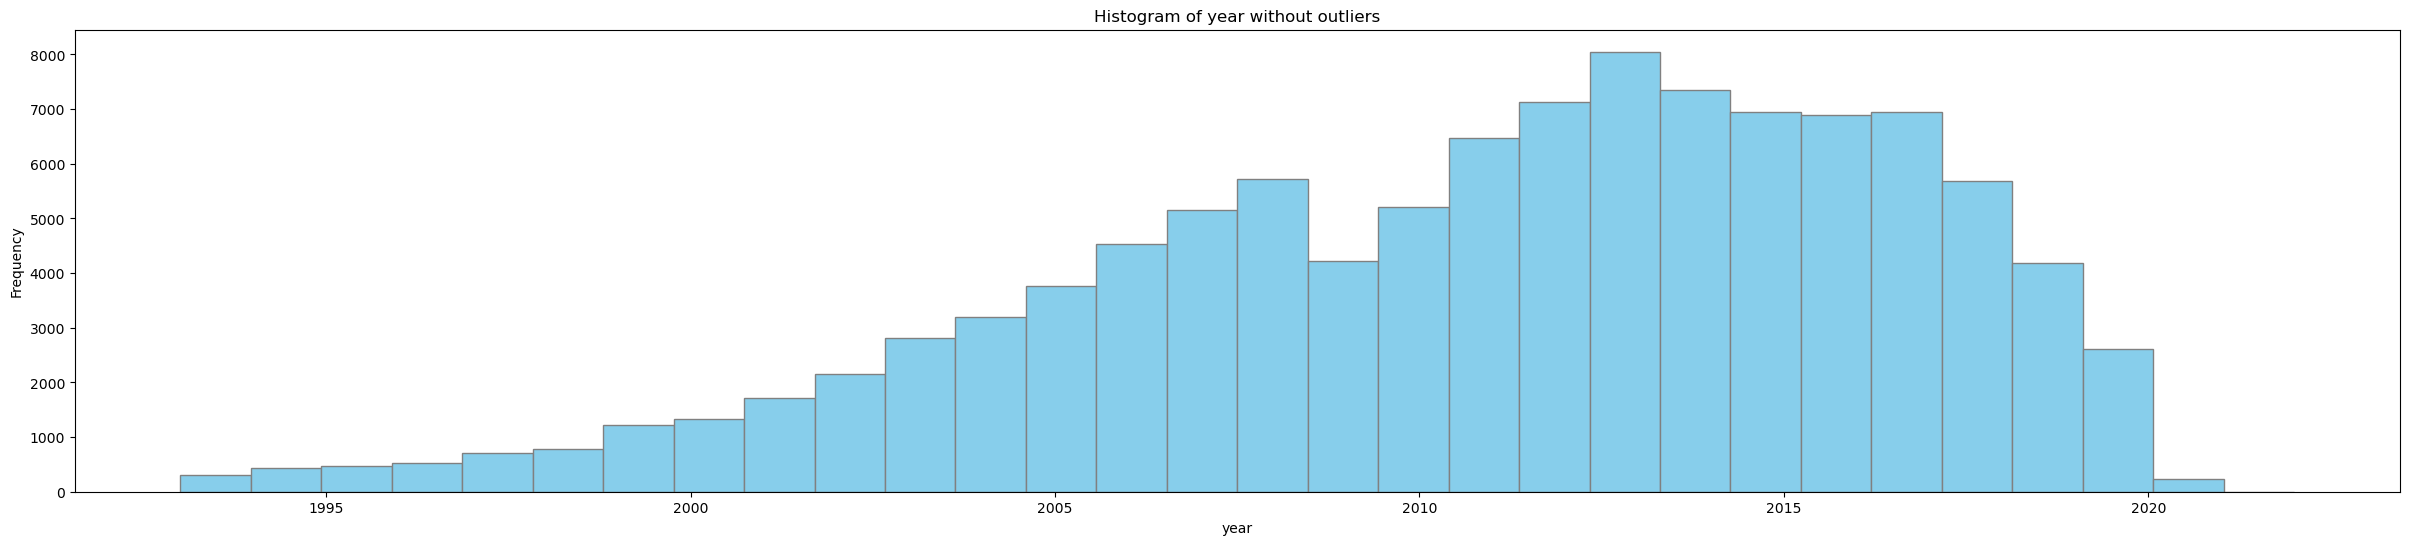

Statistics for year:
Mean: 2009.4343292020785
Standard Deviation: 9.61542855052074
Variance: 92.45646621016938
Minimum: 1900.0
25th Percentile: 2006.0
Median (50th Percentile): 2012.0
75th Percentile: 2015.0
Maximum: 2022.0
Statistics for year without outliers:
Mean: 2010.9294199205576
Standard Deviation: 5.790657881844852
Variance: 33.53171870457191
Minimum: 1993.0
25th Percentile: 2007.0
Median (50th Percentile): 2012.0
75th Percentile: 2015.0
Maximum: 2022.0


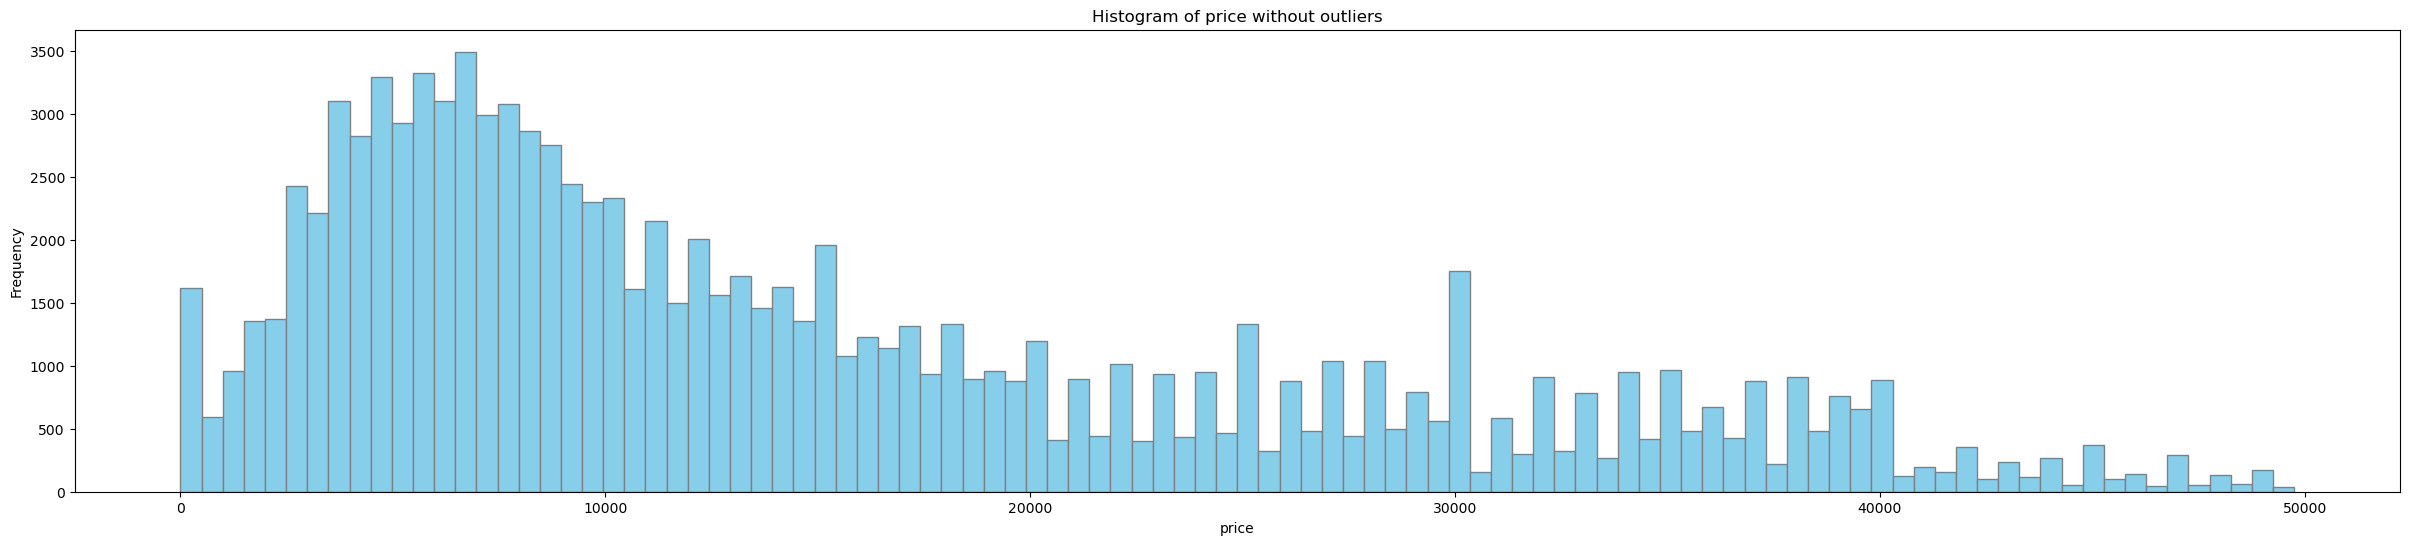

Statistics for price:
Mean: 63126.62928195141
Standard Deviation: 11697970.833716193
Variance: 136842521626474.73
Minimum: 1.0
25th Percentile: 6000.0
Median (50th Percentile): 11500.0
75th Percentile: 23500.0
Maximum: 3736928711.0
Statistics for price without outliers:
Mean: 15130.494429669436
Standard Deviation: 11595.49359942425
Variance: 134455471.81428874
Minimum: 1.0
25th Percentile: 5999.0
Median (50th Percentile): 11000.0
75th Percentile: 22482.0
Maximum: 49750.0


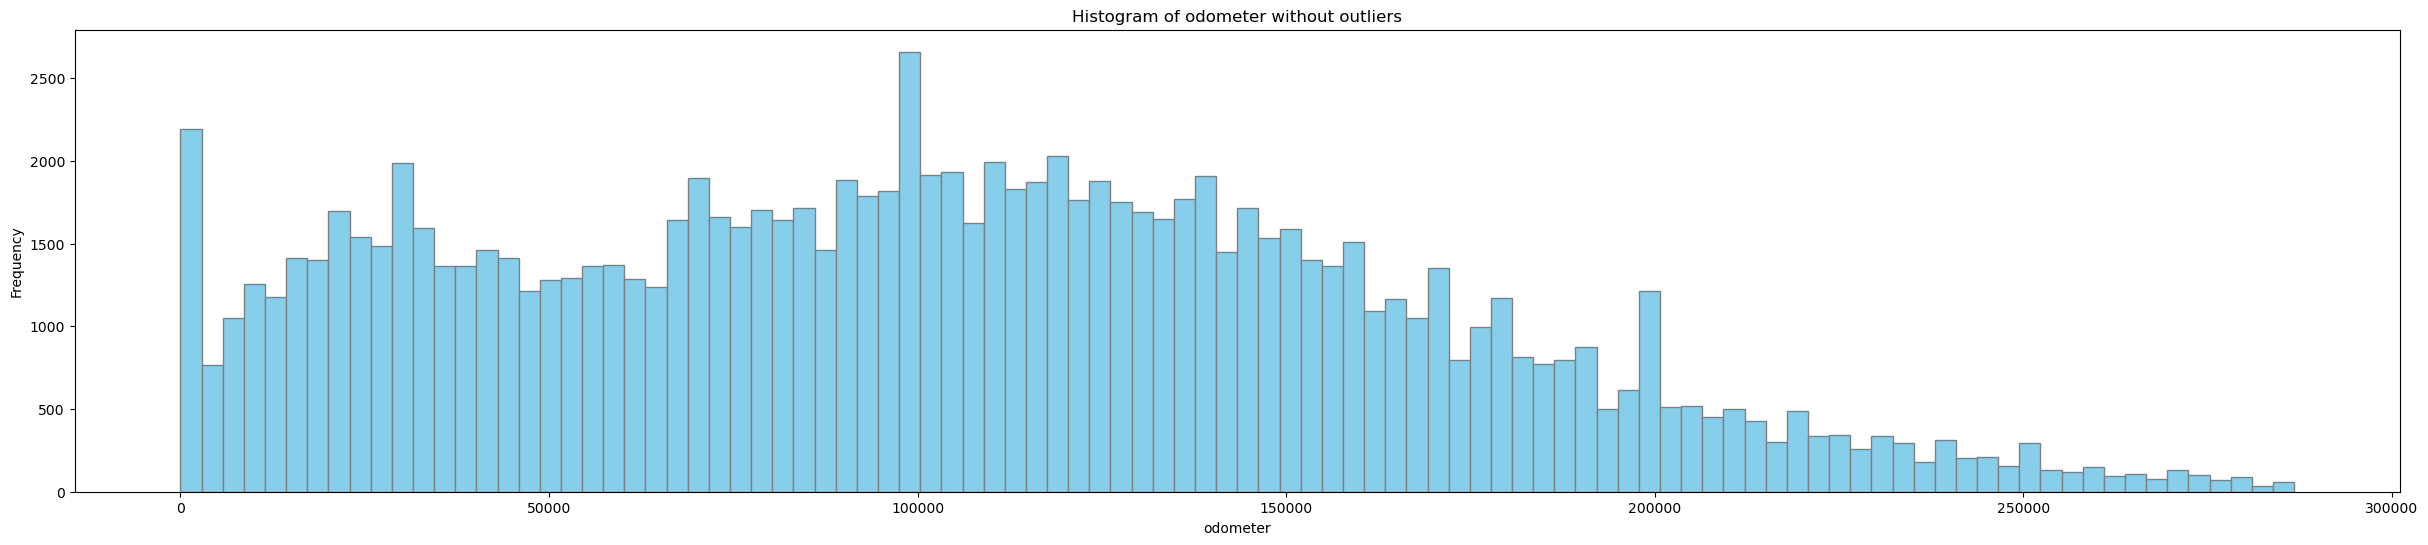

Statistics for odometer:
Mean: 111346.36988342143
Standard Deviation: 186086.47459151276
Variance: 34628176025.89772
Minimum: 1.0
25th Percentile: 56344.0
Median (50th Percentile): 103396.0
75th Percentile: 148577.0
Maximum: 10000000.0
Statistics for odometer without outliers:
Mean: 104699.76494626774
Standard Deviation: 61229.780599998456
Variance: 3749086032.3239474
Minimum: 1.0
25th Percentile: 56000.0
Median (50th Percentile): 102812.5
75th Percentile: 147000.0
Maximum: 286745.0


In [12]:
consistence = ['year', 'price','odometer']
for col in consistence:
    describe_and_plot(df, col)

### 범주형 데이터
- 연도, 제조사, condition, cylinders, transmission, type, pain_color, fulel, model

In [13]:
def plot_count_bar(data, column_name):
    # 주어진 데이터프레임에서 특정 컬럼 값에 대한 count 계산
    count_data = data[column_name].value_counts()

    # count를 기준으로 내림차순 정렬
    count_data = count_data.sort_values(ascending=False)

    # 유니크 개수
    print(f'Number of unique values of {column_name}: {len(df[column_name].unique())}')
    if len(df[column_name].unique())>15:
        top_10 = count_data[:10]
        top_10 = pd.DataFrame(top_10)
        top_10.reset_index(inplace=True)
        for i in range(10, len(top_10), 10):
            print(f'Top 10 counts of {column_name}: {top_10[column_name][i]}')
    
    # seaborn barplot 그리기
    plt.figure(figsize=(20, 6))
    sns.barplot(x=count_data.index, y=count_data.values, palette="viridis")
    plt.title(f'Count of each {column_name}')
    plt.xlabel(column_name)
    plt.ylabel('Count')
    plt.title("counts : "+col)
    if len(df[column_name].unique())>15:
        plt.xticks(rotation=45, ha='right')
    #plt.xticks(rotation=45, ha='right')
    plt.show()

Number of unique values of manufacturer: 41


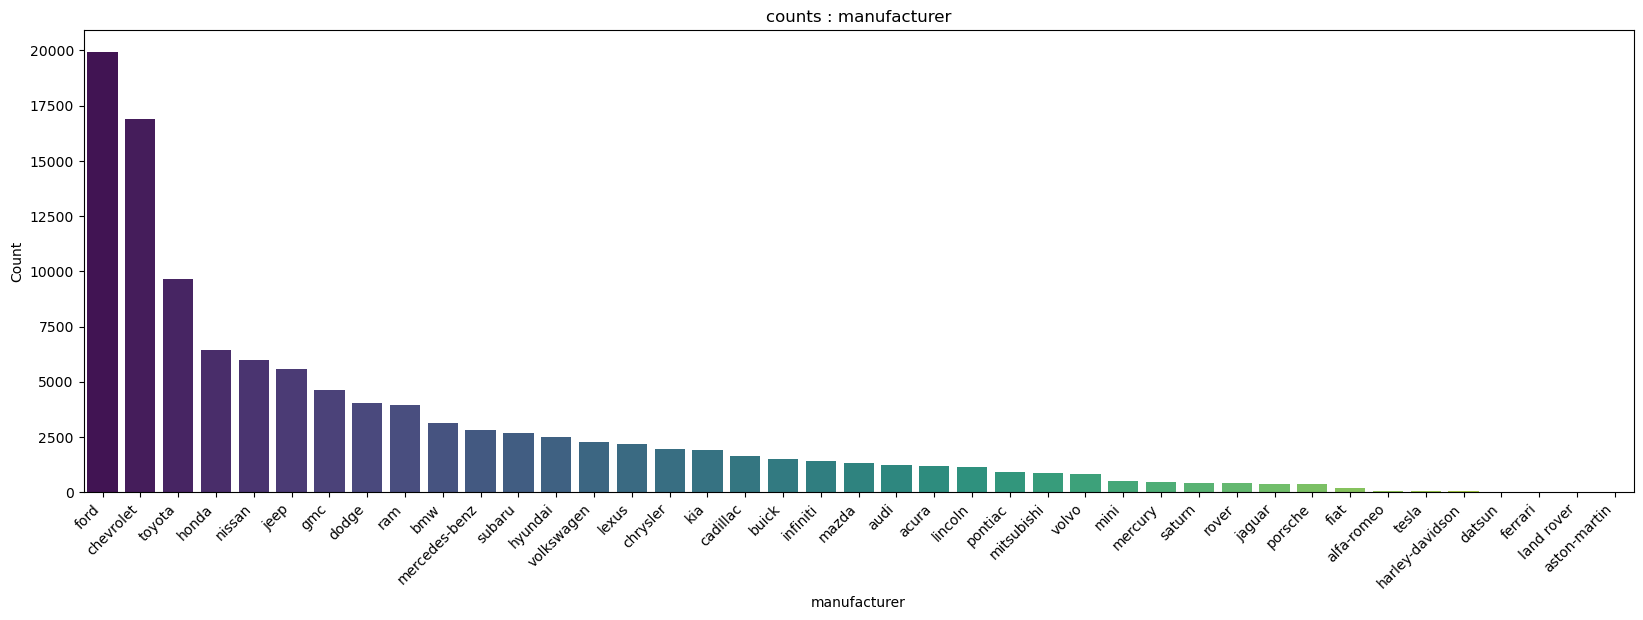

Number of unique values of condition: 6


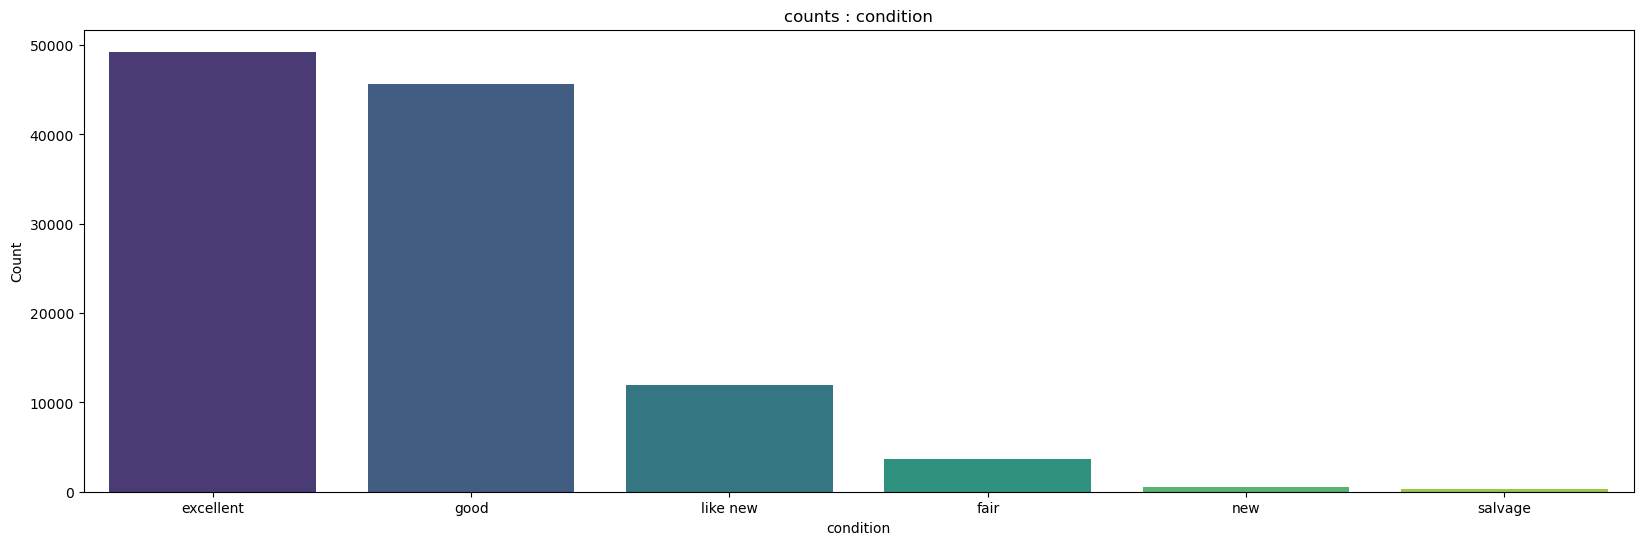

Number of unique values of cylinders: 8


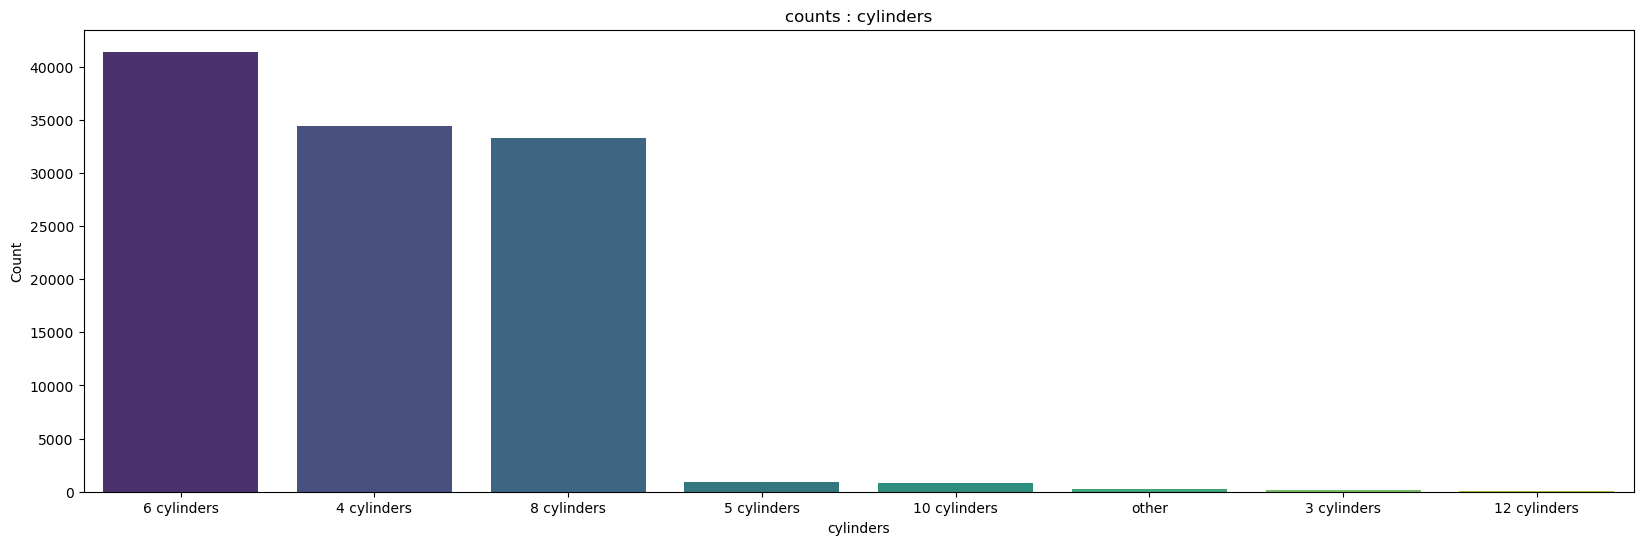

Number of unique values of fuel: 5


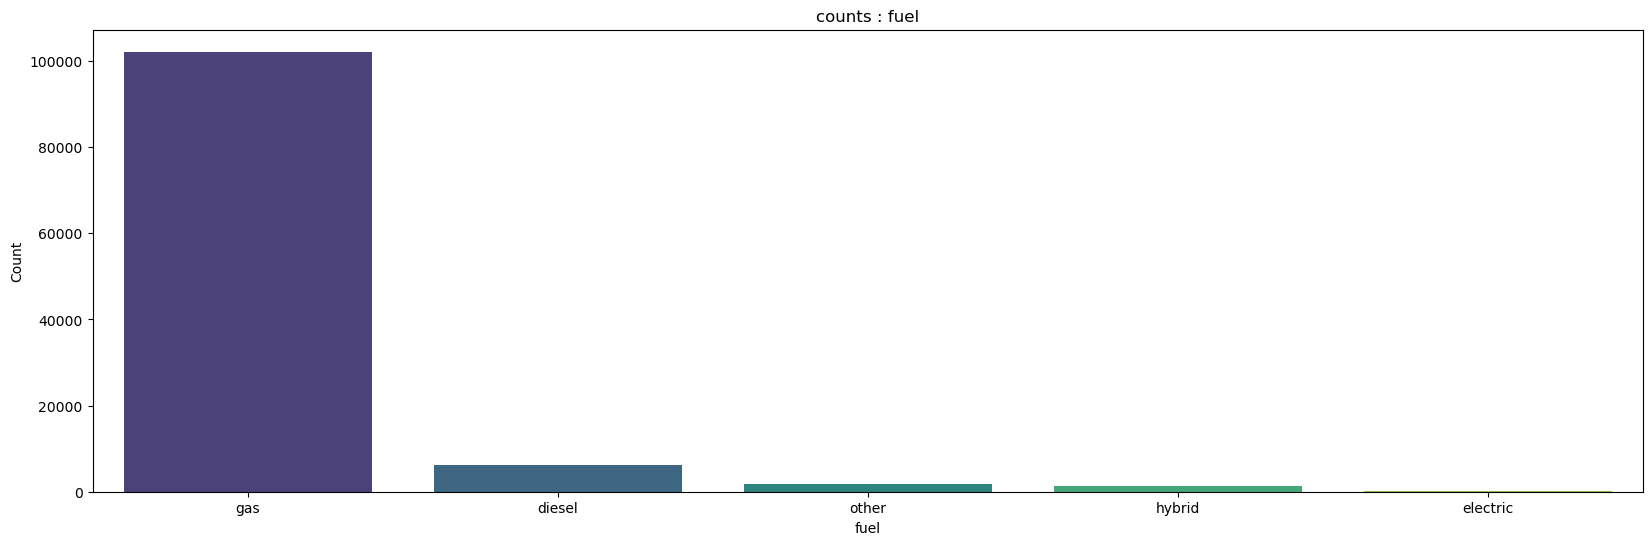

Number of unique values of transmission: 3


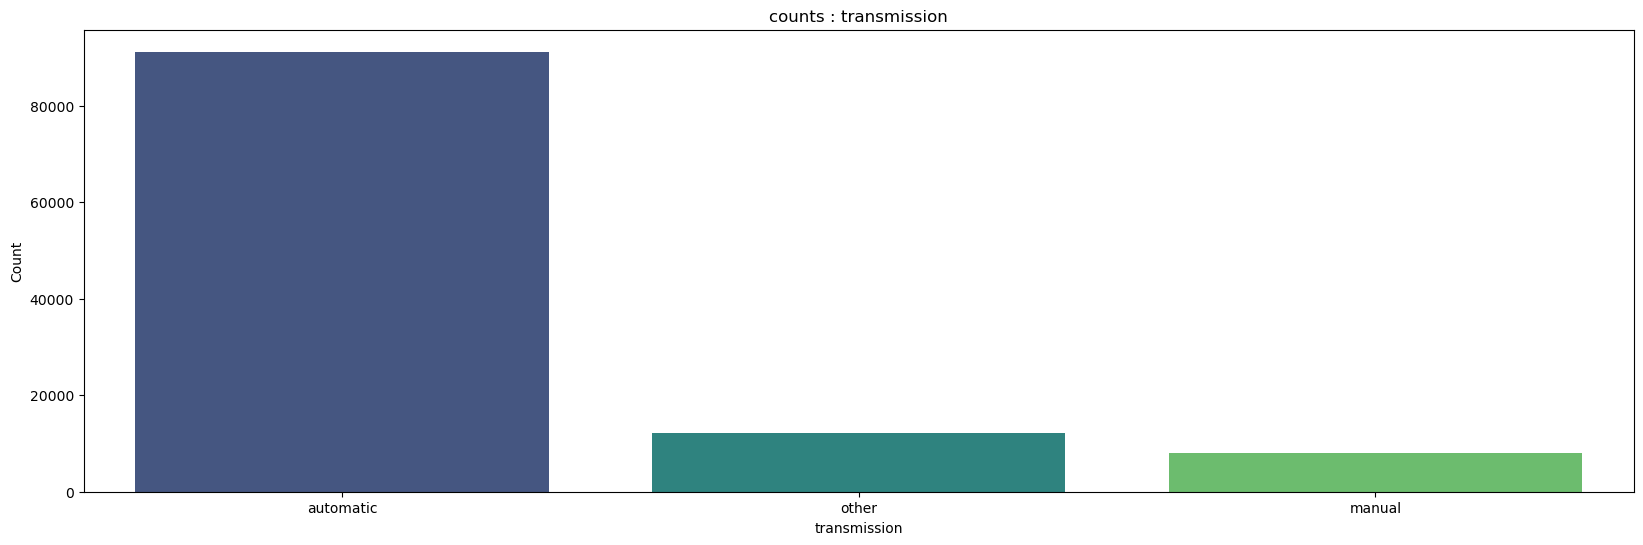

Number of unique values of drive: 3


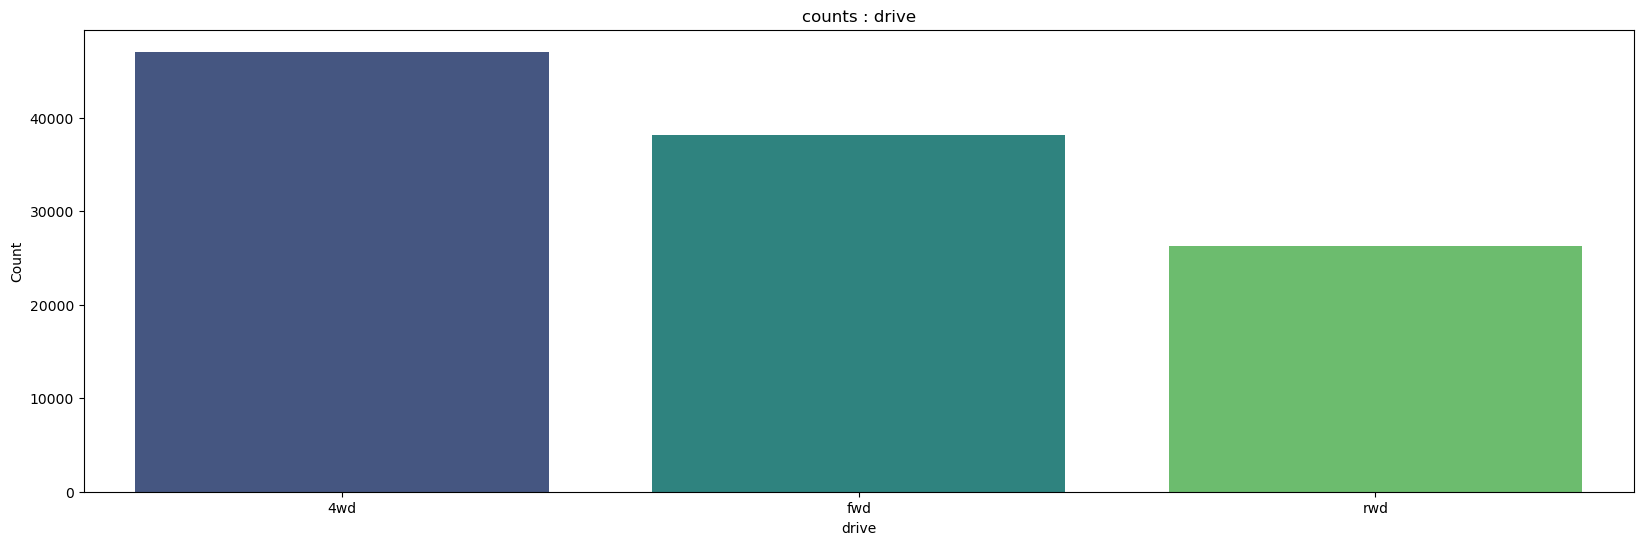

Number of unique values of type: 13


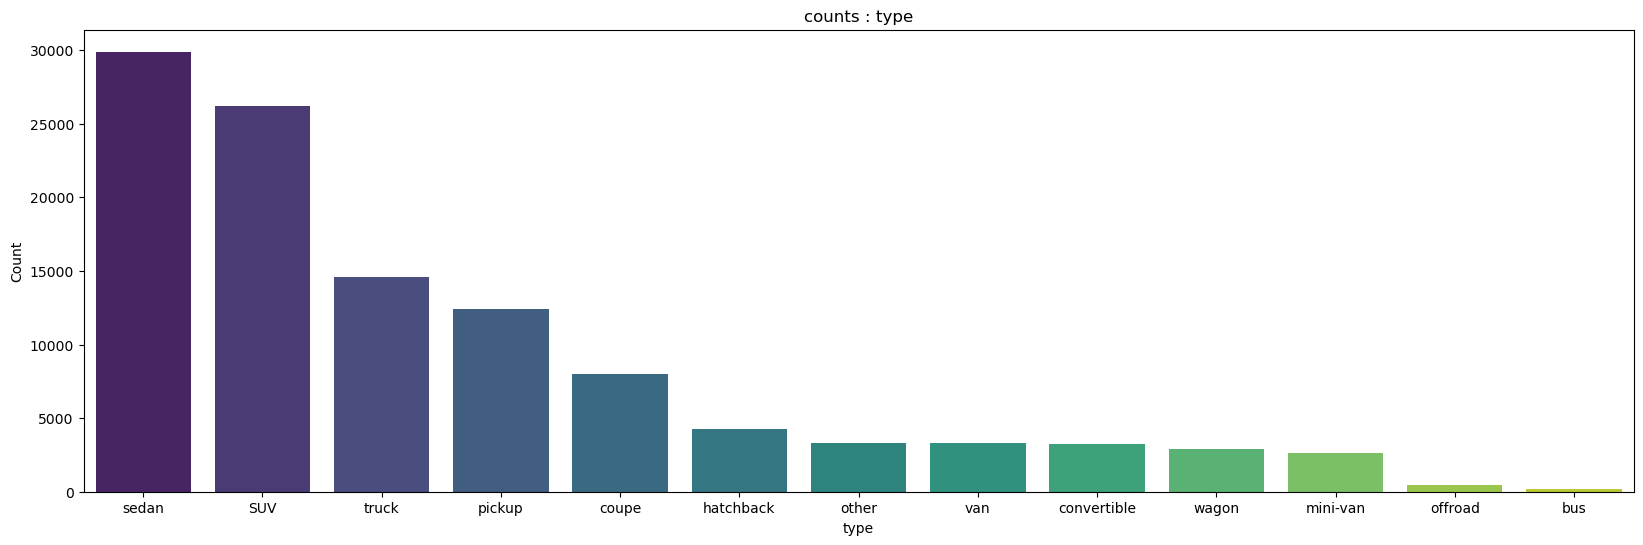

Number of unique values of paint_color: 12


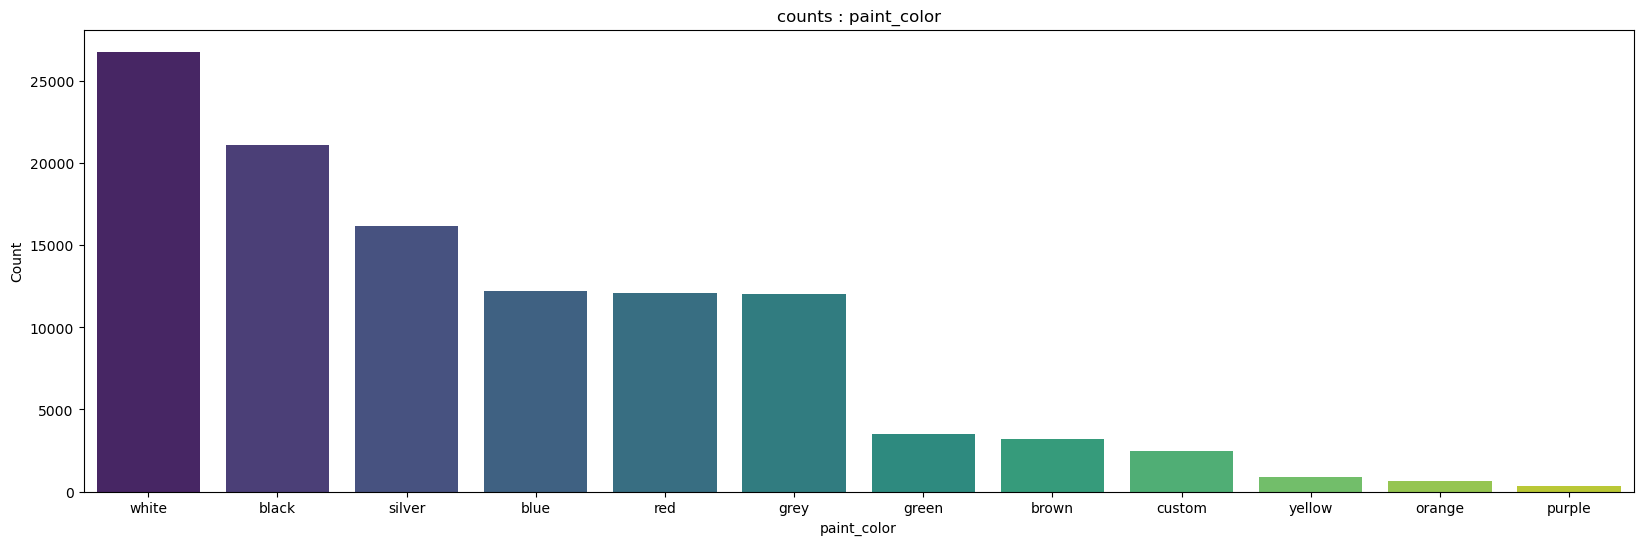

In [14]:
category_cols = ['manufacturer', 'condition', 'cylinders', 'fuel',  'transmission', 'drive', 'type', 'paint_color']
for col in category_cols:
    plot_count_bar(df, col)

### feature 간 상관관계 분석

### K-Means 클러스터링을 활용한 연속값 분류

In [79]:
def create_categorical_column(df, continuous_col, num_clusters, r_state):
    # 클러스터링을 위한 데이터 추출
    clustering_data = df[[continuous_col]]
    # KMeans 모델 훈련
    kmeans = KMeans(n_clusters=num_clusters, random_state=r_state)
    df[f'{continuous_col}_cluster'] = kmeans.fit_predict(clustering_data)
    df[f'{continuous_col}_cluster'] = df[f'{continuous_col}_cluster'].astype('int')
    #df.drop("Cluster", inplace = True, axis = 1)
    return df

In [80]:
create_categorical_column(df, 'price', 50, 50)
create_categorical_column(df, 'odometer', 100, 100)

c:\Users\user\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\user\AppData\Local\Temp\ipykernel_516\4085615534.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f'{continuous_col}_cluster'] = kmeans.fit_predict(clustering_data)
C:\Users\user\AppData\Local\Temp\ipykernel_516\4085615534.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_g

,id,price,year,manufacturer,model,condition,cylinders,fuel,odometer,transmission,drive,type,paint_color,description,price_cluster,odometer_cluster
0,7316356412,15000,2013.0,ford,f-150 xlt,excellent,6 cylinders,gas,128000.0,automatic,rwd,truck,black,2013 F-150 XLT V6 4 Door. Good condition. Leve...,28,12
1,7316343444,27990,2012.0,gmc,sierra 2500 hd extended cab,good,8 cylinders,gas,68696.0,other,4wd,pickup,black,Carvana is the safer way to buy a car During t...,35,36
2,7316304717,34590,2016.0,chevrolet,silverado 1500 double,good,6 cylinders,gas,29499.0,other,4wd,pickup,silver,Carvana is the safer way to buy a car During t...,34,52
3,7316285779,35000,2019.0,toyota,tacoma,excellent,6 cylinders,gas,43000.0,automatic,4wd,truck,grey,Selling my 2019 Toyota Tacoma TRD Off Road Dou...,34,37
4,7316257769,29990,2016.0,chevrolet,colorado extended cab,good,6 cylinders,gas,17302.0,other,4wd,pickup,red,Carvana is the safer way to buy a car During t...,13,86
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
111422,7301952155,48590,2020.0,cadillac,xt6 premium luxury,good,6 cylinders,gas,7701.0,other,fwd,other,black,Carvana is the safer way to buy a car During t...,33,40
111423,7301951544,39990,2017.0,infiniti,qx80 sport utility 4d,good,8 cylinders,gas,41664.0,automatic,4wd,other,black,Carvana is the safer way to buy a car During t...,18,88
111424,7301949190,32990,2016.0,infiniti,qx80 sport utility 4d,good,8 cylinders,gas,55612.0,automatic,rwd,other,black,Carvana is the safer way to buy a car During t...,24,87
111425,7301591199,33590,2018.0,lexus,gs 350 sedan 4d,good,6 cylinders,gas,30814.0,automatic,rwd,sedan,white,Carvana is the safer way to buy a car During t...,24,52


In [69]:
df.drop('category', axis=1, inplace=True)

C:\Users\user\AppData\Local\Temp\ipykernel_516\3129166947.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop('category', axis=1, inplace=True)


### 컬럼별 동시출현쌍 빈도 계산

In [73]:
df.columns

Index(['id', 'price', 'year', 'manufacturer', 'model', 'condition',
       'cylinders', 'fuel', 'odometer', 'transmission', 'drive', 'type',
       'paint_color', 'description', 'price_cluster', 'odometer_cluster'],
      dtype='object')

In [74]:
def plot_top_joint_occurrences(df, category_col1, category_col2, num_top=20):
    joint_occurrences = df.groupby([category_col1, category_col2]).size().reset_index(name='count')
    joint_occurrences['count'] = joint_occurrences['count'] / len(df) * 100
    top_joint_occurrences = joint_occurrences.sort_values(by='count', ascending=False).head(num_top)
    top_joint_occurrences['name'] = top_joint_occurrences[category_col1] + ' & ' + top_joint_occurrences[category_col2]
    # 바 그래프로 시각화
    top_joint_occurrences.plot(kind='bar',x='name', y='count', figsize=(20, 6),)
    plt.title(f'Top Joint Occurrences percentage ({category_col1} and {category_col2})')
    plt.xlabel(f'{category_col1} - {category_col2}')
    plt.ylabel('Percentage (%)')
    plt.xticks(rotation=45, ha='right')
    plt.show()

col_list = ['year', 'manufacturer', 'model', 'condition',
       'cylinders', 'fuel', 'transmission', 'drive', 'type',
       'paint_color', 'description', 'price_cluster', 'odometer_cluster']
# 컬럼 쌍에 대한 바 그래프 출력
for i, col1 in enumerate(col_list):
    for j, col2 in enumerate(col_list):
        if i < j:
            plot_top_joint_occurrences(df, col1, col2, num_top=20)

UFuncTypeError: ufunc 'add' did not contain a loop with signature matching types (dtype('float64'), dtype('<U3')) -> None